# What

As established in [#144](https://github.com/1jamesthompson1/TAIC-report-summary/issues/144) now that we have the safety issues dataset from #141 it is possible for us to generate the safety themes just from the safety issues.

This is supposed to be a quick example of how it could be done and what this dataset could be used for.

## Modules

To make this document easy to move all the modules needed are listed here

In [24]:
# from engine
from engine.OpenAICaller import openAICaller

from engine.Extract_Analyze import ThemeGenerator

# third party
import yaml
import pandas as pd
import numpy as np

from dotenv import load_dotenv
load_dotenv('../../.env')

import voyageai

import lancedb
from bertopic import BERTopic
from bertopic.representation import OpenAI

import openai

# built in
import os
import importlib


importlib.reload(ThemeGenerator)

client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


# Get data

I am going to read all of the safety issues from the reports.

In [25]:
output_path = "output"

safety_issues = []

all_reports = [r for r in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, r))] 

for report_id in all_reports:
    
    safety_issue_path = os.path.join(output_path, report_id, f"{report_id}_safety_issues.yaml")

    if not os.path.exists(safety_issue_path):
        continue

    with open(os.path.join(output_path, report_id, f"{report_id}_safety_issues.yaml"), "r") as f:
        si = yaml.safe_load(f)

    safety_issues.append({
        'report_id': report_id,
        'si': si
    })

In [26]:
safety_issues_df = pd.DataFrame(safety_issues)

safety_issues_df = safety_issues_df.explode('si').reset_index(drop=True)

safety_issues_df['si'] = safety_issues_df['si'].apply(lambda x: x['safety_issue'].strip())

safety_issues_df['mode'] = safety_issues_df['report_id'].apply(lambda x: int(x[5]))

safety_issues_df

,report_id,si,mode
0,2019_106,No procedures were in place to direct train cr...,1
1,2013_107,"The high incidence of brake block replacement,...",1
2,2013_107,The visual inspection regime for wheel-bearing...,1
3,2013_107,"The RailBAM system, while operational, did not...",1
4,2013_107,The lack of a dedicated RailBAM analyst positi...,1
...,...,...,...
555,2011_006,The CAA had had recurring concerns for the man...,0
556,2017_003,The maintenance inspection programme for the l...,0
557,2017_104,Transdev had no policies or procedures in plac...,1
558,2020_104,Implementation of an administrative control me...,1


<Axes: >

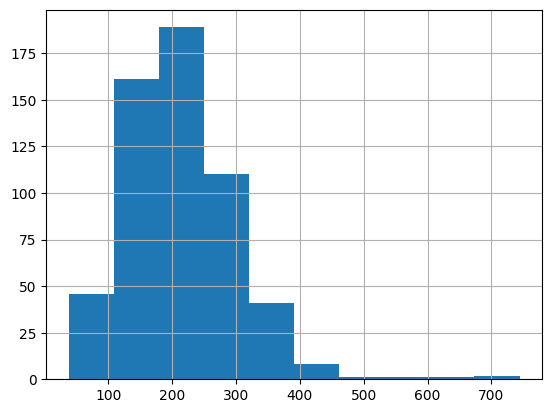

In [7]:
# Get some stats on the data and SI length

safety_issues_df['si_length'] = safety_issues_df['si'].apply(lambda x: len(x))

safety_issues_df['si_length'].hist()

# Use gpt 4 to generate safety themes

I am now going to run it through a LLM.

After attempting this using the engines current method I am going to try again to do it with vector embeddings and clustering them together. This is because we want more transparent and robust.

## Prompt preparation

In [3]:
safety_issues_str = ""

for si in safety_issues:
    si_str = "\n".join([i['safety_issue'] for i in si['si']])
            
    safety_issues_str += f"Report ID: {si['report_id']}\n{si_str}\n"

## Sending to model

In [4]:
importlib.reload(ThemeGenerator)

themeGenerator = ThemeGenerator.ThemeGenerator(output_path, {"folder_name": "{{report_id}}", "themes_file_name": "{{report_id}}_themes.yaml"}, ['aviation', 'rail', 'marine'], False)

## Getting safety themes

In [7]:
safety_theme_example = themeGenerator._get_safety_themes_from_reports(safety_issues_str)

In [ ]:
safety_themes = [themeGenerator._get_safety_themes_from_reports(safety_issues_str) for _ in range(3)]


In [ ]:
# Get the average

safety_themes_str = [
    '\n'.join([f"{safety_theme['title'].strip()} for modes {', '.join(safety_theme['modes'])}:\n {safety_theme['description']}" for safety_theme in safety_themes_set])
    for safety_themes_set in safety_themes
]

safety_themes_str = '\n\n'.join([f"Safety themes version\n'''\n{themes}\n'''\n" for themes in safety_themes_str])

print(safety_themes_str)


In [142]:

average_safety_theme = openAICaller.query(
    system="""
You are going to help me summarize the given source text.
        """,

    user=f"""
Here is the text to summarize:
'''
{safety_themes_str}
'''

Here are three versions of the safety themes extracted from a collection of accident investigation reports.

I need you to return one set that is the average of all of the safety themes versions. This means it there should be about 15 final safety themes.

Your output needs to be in yaml format. Just output the yaml structure with no extra text (This means no ```yaml and ```) . It will look something like this:
- title: |-
    title of the theme goes here
    description: |
    Multi line description of the theme goes here.
    modes:
    - modes that should be included. One per row (Each mode is just one letter (a,r,m))


=Here are some definitions=

Safety factor - Any (non-trivial) events or conditions, which increases safety risk. If they occurred in the future, these would
increase the likelihood of an occurrence, and/or the
severity of any adverse consequences associated with the
occurrence.

Safety issue - A safety factor that:
• can reasonably be regarded as having the
potential to adversely affect the safety of future
operations, and
• is characteristic of an organization, a system, or an
operational environment at a specific point in time.
Safety Issues are derived from safety factors classified
either as Risk Controls or Organizational Influences.

Safety theme - Indication of recurring circumstances or causes, either across transport modes or over time. A safety theme may
cover a single safety issue, or two or more related safety
issues.    

        """,
    model = 'gpt-4',
    temp=0
)
try:
    average_safety_theme = yaml.safe_load(average_safety_theme)
except yaml.YAMLError:
    print("Cant parse")
    print(average_safety_theme)


yaml.safe_dump(average_safety_theme, open("safety_themes.yaml", "w"))

In [ ]:
safety_themes = yaml.safe_load(open("safety_themes.yaml", "r"))

print(len(safety_themes))

safety_themes

## Grouping safety themes

In [148]:
safety_theme_groups = themeGenerator._group_safety_themes(safety_themes)

In [11]:
# Edit each title to remove trailing newline

for group in safety_theme_example:
    group['title'] = group['title'].strip()


safety_theme_example

[{'title': 'Non-compliance with Procedures',
  'description': 'This theme involves instances where individuals or teams do not adhere to established safety procedures, protocols, or regulations. This can include failure to follow standard operating procedures, maintenance protocols, or regulatory requirements. Non-compliance can lead to unsafe conditions, increased risk of accidents, and potential harm. It underscores the importance of strict adherence to safety guidelines and the need for robust oversight and training to ensure compliance.\n',
  'modes': ['a', 'r', 'm']},
 {'title': 'Inadequate Communication',
  'description': 'Inadequate communication refers to failures or deficiencies in the exchange of critical information among team members, between different teams, or with external entities. This can include miscommunication, lack of clarity, or failure to share important safety-related information. Such communication failures can lead to misunderstandings, misaligned actions, an

In [12]:


safety_theme_groups_example = themeGenerator._group_safety_themes(safety_theme_example)

In [149]:
safety_theme_groups

[{'title': 'Human Factors and Training',
  'description': 'This group focuses on the human element in operational safety, emphasizing the importance of training, non-technical skills, and managing human vulnerabilities such as fatigue.\n',
  'themes': ['Inadequate Training and Familiarization',
   'Human Factors and Non-Technical Skills',
   'Fatigue Management']},
 {'title': 'Safety Management and Organizational Practices',
  'description': 'Themes in this group relate to the overarching systems and cultural practices within organizations that support or undermine safety, including the management of safety information and the cultivation of a safety culture.\n',
  'themes': ['Safety Management Systems Deficiencies',
   'Safety Culture and Organizational Influences',
   'Regulatory and Oversight Deficiencies']},
 {'title': 'Operational and Technical Safeguards',
  'description': 'This group encompasses the technical and procedural aspects of safety, focusing on the design, maintenance,

## Add groups to original safety themes

In [14]:
# Add a field to each safety theme that is the group it belongs to

def combine_groups_with_themes(safety_theme_groups, safety_themes):

    safety_themes_with_groups = []

    for theme in safety_themes:
        for group in safety_theme_groups:
            if theme['title'] in group['themes']:
                theme['group'] = group['title']
                safety_themes_with_groups.append(theme)
                break

    return safety_themes_with_groups

In [15]:
safety_theme_example_with_groups = combine_groups_with_themes(safety_theme_groups_example, safety_theme_example)

## Prepare xlsx spreadsheet to share with chris and ingrid

I need to give a spreadsheet to them so that they can appreicate what the results are.

In [13]:
# First page has all the safety themes
# Second page has the groups

def send_to_excel(safety_themes_with_groups, safety_theme_groups, file_name):

    writer = pd.ExcelWriter("generated_safety_themes.xlsx", engine="openpyxl")

    pd.DataFrame(safety_themes_with_groups)[['title', 'description', 'group']].to_excel(writer, sheet_name="Safety Themes", index=False)

    pd.DataFrame(safety_theme_groups).to_excel(writer, sheet_name="Safety Theme Groups", index=False)

    writer.close()

In [16]:
send_to_excel(safety_theme_example_with_groups, safety_theme_groups_example, "safety_themes.xlsx")

After performing this multiple times I am noticing that it varies a bit.

I would like to take an average.

# Generating safety themes with clustering

As per https://github.com/1jamesthompson1/TAIC-report-summary/issues/144#issuecomment-2084207763 a different method will be looked into for safety theme generation.

This will be embedding the safety issues and then clustering them.

## Using VoyageAI to embed safety issues

I will use voyageAI to embed safety issues into its vector space. Then I can use clustering based off the distances.


After a quick look this doesn't seem to be working. I will look at other methods before returning.

### Embed the safety issues in a vector space

In [63]:
# Perform the embedding with voyageAI

vo = voyageai.Client()

safety_issues_df['si_embedding'] = safety_issues_df['si'].apply(lambda x: vo.embed(x, model="voyage-large-2", input_type="document").embeddings[0])

safety_issues_df.to_pickle("safety_issues_embedded.pkl")


### Perform clustering

In [64]:
# Read the embeddings from the file
safety_issues_embeddings = pd.read_pickle("safety_issues_embedded.pkl")

In [65]:
# Take embeddings column and make dataframe of just a vector per row

just_embeddings = pd.DataFrame([pd.Series(x[3]) for x in safety_issues_embeddings.itertuples()])

just_embeddings.to_csv("safety_issues_embeddings.tsv", sep='\t', header=False, index=False)

safety_issues_df[['report_id', 'si']].to_csv("safety_issues.tsv", sep='\t', header=True, index=False)

just_embeddings

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,-0.012771,0.007343,0.015513,0.020382,0.049170,-0.016087,-0.026330,-0.017496,-0.054257,0.028558,...,0.022865,0.005581,-0.018963,-0.003472,-0.009569,0.014210,-0.004824,-0.021475,0.031222,-0.053200
1,-0.014539,-0.001597,0.028008,0.020425,0.036622,0.013073,-0.028131,-0.026387,-0.040509,0.019026,...,0.021860,0.005419,-0.023725,0.006567,0.015615,0.026924,0.009052,0.001831,0.067552,-0.050005
2,-0.020324,0.031775,0.041102,0.003020,0.032913,0.002090,-0.023881,-0.046433,-0.041981,0.015159,...,0.015166,0.008495,-0.033217,0.005024,-0.014280,0.028872,-0.000845,-0.022189,0.062688,-0.041889
3,-0.036478,0.016818,0.020148,-0.003851,0.029179,-0.010371,-0.022696,-0.016911,-0.040015,0.023737,...,0.008360,0.007836,-0.004433,-0.007466,-0.006782,0.024270,0.003014,-0.015723,0.028897,-0.038721
4,-0.027892,0.012514,0.020006,-0.005288,0.035091,0.002491,-0.028382,-0.029777,-0.051497,0.022908,...,0.009944,0.018888,-0.024896,-0.004109,-0.004096,0.024149,0.006429,-0.003811,0.047033,-0.042707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,-0.009620,0.024406,0.022657,0.010728,0.028483,0.010987,-0.031022,-0.020002,-0.048104,0.014938,...,0.023166,0.009700,0.007783,-0.002382,0.009752,0.028909,0.009783,-0.024294,0.026408,-0.024198
556,-0.001311,0.023869,0.035086,0.030096,0.047925,-0.002665,-0.032979,-0.022631,-0.050749,0.004632,...,0.023711,0.017195,-0.024494,-0.004724,-0.012647,0.009509,0.005017,-0.001948,0.038466,-0.048223
557,0.001366,0.003985,0.016365,0.034781,0.041152,0.011839,-0.025788,-0.014149,-0.052502,0.022246,...,0.027706,0.013397,-0.005452,-0.003213,0.002592,0.031519,0.004491,-0.024112,0.028020,-0.047770
558,-0.021135,0.016762,0.037195,0.032336,0.031156,0.018676,-0.017881,-0.046530,-0.046043,0.018097,...,0.036351,0.017829,0.018269,0.018482,0.014049,0.027027,0.024005,-0.005656,0.033307,-0.028446


In [80]:
# Check with a vector db actually how useful the embeddings are

uri = 'checking_embeddings_db'
db = lancedb.connect(uri)

db.drop_table('safety_issues')

tbl = db.create_table('safety_issues', safety_issues_embeddings.rename({'si_embedding': 'vector'}, axis =1))

tbl.head()

pyarrow.Table
report_id: string
si: string
vector: fixed_size_list<item: float>[1536]
  child 0, item: float
----
report_id: [["2019_106","2013_107","2013_107","2013_107","2013_107"]]
si: [["No procedures were in place to direct train crews and controllers in the action to be taken in the event of berthing on the West Main Line.","The high incidence of brake block replacement, which can contribute to premature bearing failure, was not addressed by putting the wagon under an enhanced monitoring and inspection schedule.","The visual inspection regime for wheel-bearings is not an effective means of managing and preventing total wheel-bearing failure, as it failed to detect the impending failure in this case.","The RailBAM system, while operational, did not effectively prevent the derailment due to the procedures in place at the time, which did not prioritize the investigation and remediation of detected faults unless they reached a severity level that was considered critical.","The lack o

In [85]:
results = tbl.search(safety_issues_df.loc[0, 'si_embedding']).to_pandas()

results

,report_id,si,vector,_distance
0,2019_106,No procedures were in place to direct train cr...,"[-0.012770711, 0.0073434557, 0.015512638, 0.02...",0.000000
1,2017_104,Transdev had no policies or procedures in plac...,"[0.0013659622, 0.003985189, 0.016365385, 0.034...",0.203681
2,2012_102,The management and maintenance of the emergenc...,"[-0.018781533, 0.0063720574, 0.027896337, 0.01...",0.222293
3,2011_105,The train driver did not challenge the train c...,"[-0.01931065, 0.016147465, 0.02717078, 0.01908...",0.223187
4,2012_105,Miscommunication between the train driver and ...,"[-0.0061542424, 0.0074667484, 0.038467832, 0.0...",0.223974
5,2011_106,The train controller made an assumption about ...,"[-0.011479956, 0.025100237, 0.041023806, 0.013...",0.224656
6,2011_102,A planned change to the train controller's wor...,"[-0.013791946, 0.0009523342, 0.02111612, 0.015...",0.224926
7,2011_102,The train controller received insufficient sup...,"[-0.013256299, 0.0063922475, 0.021408884, 0.01...",0.230861
8,2016_102,"the train controller, the train driver and the...","[-0.0015806541, 0.01729786, 0.028932491, 0.009...",0.232185
9,2018_102,The procedure for manually setting and isolati...,"[-0.013324865, 0.012236615, 0.023555424, 0.013...",0.233126


### Summarize clusters

## using openAI to perform embedding

I have tried using voyageAI as the embedding. However there are problems with the bertopic model only generated three clusters.

### Getting embeddings

In [47]:
safety_issues_df['si_embedding_openai'] = safety_issues_df['si'].apply(lambda x: client.embeddings.create(
    input=x,
    model="text-embedding-3-large"
).data[0].embedding)

safety_issues_df.to_pickle("safety_issues_embedded_openai.pkl")

## Generating themes using BERTopic

This was used by the https://australasiantransportresearchforum.org.au/wp-content/uploads/2023/12/ATRF_2023_Paper_19.pdf paper. It might actually yet prove useful.

Lets try it out.

### Base attempt

This seems to of failed. I believe this is mainly due to the fact that each documents are really short.

In [94]:
topic_model = BERTopic()

topics, probs = topic_model.fit_transform(safety_issues_df['si'])

In [98]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,138,-1_the_of_to_and,"[the, of, to, and, was, in, for, not, train, had]",[There are a number of reasonable measures tha...
1,0,159,0_the_of_and_to,"[the, of, and, to, in, not, on, management, wa...",[The standard of passage planning on board the...
2,1,119,1_the_to_of_pilots,"[the, to, of, pilots, and, not, flight, for, t...",[While ATC sequences an IFR aeroplane to land ...
3,2,41,2_train_the_and_controller,"[train, the, and, controller, of, to, incident...",[The train driver did not challenge the train ...
4,3,32,3_the_maintenance_in_engine,"[the, maintenance, in, engine, to, and, that, ...","[The CO2 system's pilot cylinder leaked, but t..."
5,4,28,4_kiwirail_the_that_to,"[kiwirail, the, that, to, kiwirails, of, prote...",[KiwiRail's system for training and assessment...
6,5,17,5_road_level_crossings_vehicles,"[road, level, crossings, vehicles, crossing, b...",[Level crossing assessments do not require the...
7,6,13,6_gear_landing_nose_the,"[gear, landing, nose, the, down, locked, hydra...",[The failure of the nose landing gear to exten...
8,7,13,7_braking_brake_the_lowadhesion,"[braking, brake, the, lowadhesion, matangi, wh...",[The National Rail System Standards (NRSS) did...


### Using Openai as topic representation model

In [107]:

representation_model = OpenAI(
    client,
    model="gpt-4-turbo",
    chat=True,
    nr_docs = 50)

topic_model = BERTopic(representation_model=representation_model)

topics, probs = topic_model.fit_transform(safety_issues_df['si'])

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,198,-1_Transportation Safety and Risk Management I...,[Transportation Safety and Risk Management Iss...,[The absence of selcall capability on the Well...
1,0,116,0_Rail Safety and Operational Challenges in Ki...,[Rail Safety and Operational Challenges in Kiw...,[The training that drivers received for transi...
2,1,40,1_Maritime Navigation and Safety Management De...,[Maritime Navigation and Safety Management Def...,[The voyage planning for the time in the Snare...
3,2,37,2_Maintenance and Safety Failures in Engine an...,[Maintenance and Safety Failures in Engine and...,[The standard of maintenance for a safety-crit...
4,3,30,3_Maritime Safety Violations and Incidents,[Maritime Safety Violations and Incidents],[The skipper did not have the requisite knowle...
5,4,25,4_Maritime Safety Management and Crew Practices,[Maritime Safety Management and Crew Practices],[It could not be established what training the...
6,5,25,5_Challenges and Risks in Helicopter Operations,[Challenges and Risks in Helicopter Operations],"[Due to their unique main rotor design, during..."
7,6,24,6_Aviation and Maritime Regulatory and Operati...,[Aviation and Maritime Regulatory and Operatio...,[The standard of pilot training and the superv...
8,7,22,7_Air Traffic Control and Pilot Communication ...,[Air Traffic Control and Pilot Communication I...,[Had the controllers realised that the low clo...
9,8,18,8_Safety Risks at Road and Rail Level Crossings,[Safety Risks at Road and Rail Level Crossings],[Level crossing assessments do not require the...


After first running this it seems to be much more promising.

I have 13 groups however the catch is that 230 of them are considered "outliers". This means that they are not grouped at all which is not very useful.

I will try increasing the nr_docs as my context limit allows this.

### Using keyBERTInspired

In [109]:
from bertopic.representation import KeyBERTInspired

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)

topic_model.fit_transform(safety_issues_df['si'])

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,233,-1_trains_safety_rail_train,"[trains, safety, rail, train, track, incident,...","[There are four factors that were not, but sho..."
1,0,41,0_maintenance_inspection_compressor_defect,"[maintenance, inspection, compressor, defect, ...",[Indications that the right-hand engine was no...
2,1,40,1_bridge_pilotage_standards_maritime,"[bridge, pilotage, standards, maritime, voyage...",[A light beacon placed on Astrolabe Reef is an...
3,2,33,2_kiwirail_kiwirails_rail_protection,"[kiwirail, kiwirails, rail, protection, track,...",[The track ganger should have recognised that ...
4,3,30,3_skipper_passengers_rider_sinking,"[skipper, passengers, rider, sinking, voyage, ...",[The skipper did not have the requisite knowle...
5,4,26,4_crew_safety_onboard_rescue,"[crew, safety, onboard, rescue, hazards, cadet...",[The rescue response from the vessel's master ...
6,5,26,5_rotors_rotor_helicopters_helicopter,"[rotors, rotor, helicopters, helicopter, accid...","[Due to their unique main rotor design, during..."
7,6,25,6_pilots_aviation_circling_flight,"[pilots, aviation, circling, flight, airspace,...",[When an IFR aeroplane is approved to conduct ...
8,7,23,7_pilotage_pilot_aviation_pilots,"[pilotage, pilot, aviation, pilots, airlines, ...",[Conduct of the aerial hunting operation poten...
9,8,18,8_crossings_intersections_crossing_roads,"[crossings, intersections, crossing, roads, in...",[Level crossing assessments do not require the...


### Using pregenerated embeddings

There is a current problem that most of the issues are discarded as outliers.

#### Voyage embeddings

In [50]:

voyageai_embeddings = pd.read_pickle('safety_issues_embedded.pkl')['si_embedding']

column_to_2darray = lambda column: np.array([np.array(x) for x in column.to_numpy()])

array_2d = column_to_2darray(voyageai_embeddings)

In [45]:
topic_model = BERTopic()

topic, prob = topic_model.fit_transform(safety_issues_df['si'], array_2d)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5,-1_the_dooralert_load_ganz,"[the, dooralert, load, ganz, of, runway, and, ...",[The design of the passenger door-alert system...
1,0,379,0_the_of_to_and,"[the, of, to, and, in, not, for, was, that, on]",[Eight of the 12 vessels managed by CIEL had h...
2,1,158,1_the_train_to_and,"[the, train, to, and, of, not, in, was, that, ...",[The training that drivers received for transi...
3,2,18,2_road_level_crossings_the,"[road, level, crossings, the, crossing, vehicl...",[Level crossing assessments do not require the...


This runs alright and doesn't have outliers however there is a problem that there are only 3 groups. I need to expand it out to have more groups.

In [43]:
representation_model = OpenAI(
    client,
    model="gpt-4-turbo",
    chat=True,
    nr_docs = 50)

In [44]:
topic_model = BERTopic(representation_model=representation_model)

topic, prob = topic_model.fit_transform(safety_issues_df['si'], array_2d)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3,-1_Transportation Safety and Infrastructure Co...,[Transportation Safety and Infrastructure Conc...,[The MDD class special-movement wagon allocate...
1,0,380,0_Maritime and Aviation Safety Management Fail...,[Maritime and Aviation Safety Management Failu...,[KiwiRail did not follow the manufacturer's ad...
2,1,159,1_Issues in Train Management and Safety Regula...,[Issues in Train Management and Safety Regulat...,[The training that drivers received for transi...
3,2,18,2_Road and Rail Level Crossing Safety Concerns,[Road and Rail Level Crossing Safety Concerns],[Level crossing assessments do not require the...


This has made the topic reprseentation better but still doesnt have ghood clusters.

I will try again using openai embeddings

#### OpenAI embeddings

In [17]:
openai_embeddings = pd.read_pickle('safety_issues_embedded_openai.pkl')

In [74]:
topic_model = BERTopic(representation_model=representation_model)

topic, prob = topic_model.fit_transform(openai_embeddings['si'], column_to_2darray(openai_embeddings['si_embedding_openai']))

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1,-1_Addressing Non-compliance Risks,[Addressing Non-compliance Risks],"[Non-compliance, unless addressed as soon as p..."
1,0,203,0_Aviation Safety and Compliance Issues,[Aviation Safety and Compliance Issues],[Assuming that the reason for the nose landing...
2,1,188,1_Safety and Management Issues in Rail Operations,[Safety and Management Issues in Rail Operations],[The errors in the work plan submitted; the om...
3,2,168,2_Maritime Safety and Management Deficiencies,[Maritime Safety and Management Deficiencies],[The standard of passage planning on board the...


This is working arlight but it has the problem of only 4 groups. It seems from the topic representation that it is being split along mode lines.

In [179]:


openai_embeddings['topic'] = topic

openai_embeddings['mode'] = openai_embeddings['report_id'].apply(lambda x: x[5])

openai_embeddings

# Make a table where there are the counts and x axis is topic and y axis is mode
safety_issues_df_topic_mode = openai_embeddings.pivot_table(index='topic', columns='mode', values='report_id', aggfunc='count').fillna(0)
safety_issues_df_topic_mode

ValueError: Length of values (206) does not match length of index (560)

This lines up with what the topic representations were showing. A possible solution to this could be doing this on only one mode and then trying to merge some of the topics togather?

#### Testing out single mode

In [154]:
av_safety_issues_df = openai_embeddings[openai_embeddings['mode'] == '0']

av_safety_issues_df

,report_id,si,si_length,si_embedding_openai,topic,mode
7,2011_003,The New Zealand regulatory system has not prov...,251,"[0.018687840551137924, -0.0004576667561195791,...",0,0
8,2011_003,The format of the Robinson R22 helicopter flig...,210,"[0.010166238062083721, -0.03145092353224754, -...",0,0
9,2011_003,The rate of R22 in-flight break-up accidents i...,181,"[0.005362064577639103, -0.02270277962088585, -...",0,0
10,2011_003,"The crashworthiness of the ELT, which was desi...",121,"[0.014956376515328884, 0.015346664004027843, -...",0,0
16,2010_010,The failure of the nose landing gear to extend...,255,"[-0.004196920432150364, 0.04126189276576042, 0...",0,0
...,...,...,...,...,...,...
547,2015_001,Parachute drop pilots were not required to wea...,301,"[0.02531621977686882, -0.023382065817713737, -...",2,0
553,2011_006,The council had not evaluated the effects of t...,152,"[-0.027672406286001205, 0.016233913600444794, ...",1,0
554,2011_006,The standard of pilot training and the supervi...,115,"[0.015234002843499184, -0.01887856051325798, 0...",0,0
555,2011_006,The CAA had had recurring concerns for the man...,219,"[0.001043604570440948, 0.00177335599437356, 0....",0,0


In [129]:
topic_model = BERTopic(representation_model=representation_model, calculate_probabilities=True)

topics, probs = topic_model.fit_transform(av_safety_issues_df['si'], column_to_2darray(av_safety_issues_df['si_embedding_openai']))

topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,55,-1_Aviation Safety and Maintenance Issues,[Aviation Safety and Maintenance Issues],[There was a low likelihood of the weather con...
1,0,45,0_Aviation Safety and Operational Misunderstan...,[Aviation Safety and Operational Misunderstand...,[The procedure for circling below the minimum ...
2,1,32,1_Aviation Safety and Compliance Concerns,[Aviation Safety and Compliance Concerns],[The operator had been allowed to continue pro...
3,2,29,2_Safety Issues and Risks in Robinson Helicopt...,[Safety Issues and Risks in Robinson Helicopte...,[The importance of some critical safety inform...
4,3,19,3_Aircraft Landing Gear and Door Lock Failures,[Aircraft Landing Gear and Door Lock Failures],[Had the pilots known that the nose landing ge...
5,4,13,4_Aviation Safety and Emergency Response Delays,[Aviation Safety and Emergency Response Delays],[The failure of the emergency locator transmit...
6,5,13,5_Aircraft Component Failures and Maintenance ...,[Aircraft Component Failures and Maintenance I...,[The isolated nature of the component failure ...


In [152]:
new_topics = topic_model.reduce_outliers(documents=av_safety_issues_df['si'].to_list(), topics=topics, probabilities=probs, strategy="probabilities")

topic_model.update_topics(av_safety_issues_df['si'].to_list(), topics=new_topics, representation_model=representation_model)

topic_model.get_topic_info()

2024-05-02 14:21:31,410 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,Representation,Representative_Docs
0,0,45,0_Aviation Safety and Procedure Compliance at ...,[Aviation Safety and Procedure Compliance at A...,[The procedure for circling below the minimum ...
1,1,51,1_Aviation Safety and Regulatory Oversight Con...,[Aviation Safety and Regulatory Oversight Conc...,[The operator had been allowed to continue pro...
2,2,34,2_Safety Issues and Accident Risks in Robinson...,[Safety Issues and Accident Risks in Robinson ...,[The importance of some critical safety inform...
3,3,22,3_Aircraft Safety and Malfunction Issues,[Aircraft Safety and Malfunction Issues],[Had the pilots known that the nose landing ge...
4,4,25,4_Aviation Safety and Emergency Management,[Aviation Safety and Emergency Management],[The failure of the emergency locator transmit...
5,5,29,5_Aircraft Maintenance and Safety Issues,[Aircraft Maintenance and Safety Issues],[The isolated nature of the component failure ...


In [156]:
av_safety_issues_df['topic'] = new_topics

av_safety_issues_df = pd.concat([av_safety_issues_df.reset_index(drop=True), pd.DataFrame(probs)], axis=1)

In [ ]:

for i in topic_model.get_topic_info()['Name']:
    print(i)


0_Aviation Safety and Procedure Compliance at Aerodromes
1_Aviation Safety and Regulatory Oversight Concerns
2_Safety Issues and Accident Risks in Robinson Helicopter Operations
3_Aircraft Safety and Malfunction Issues
4_Aviation Safety and Emergency Management
5_Aircraft Maintenance and Safety Issues


I am pleased with how well this has worked. Some of the representation names could be worked on a bit but the actual groups are useful albeit not that specific.


#### Run BerTopic for each mode using openAI embeddings

After testing above with the aviation it seems to be reasonable to have a look at all of them.

In [13]:
column_to_2darray = lambda column: np.array([np.array(x) for x in column.to_numpy()])

def runBERTopic(df, docs_name, embeddings_name, representation_model):

    topic_model = BERTopic(
        representation_model=representation_model,
        calculate_probabilities=True)

    topics, probs = topic_model.fit_transform(
        df[docs_name],
        column_to_2darray(df[embeddings_name]))

    new_topics = topic_model.reduce_outliers(
        documents=df[docs_name].to_list(),
        topics=topics, 
        probabilities=probs,
        strategy="probabilities")

    topic_model.update_topics(
        df[docs_name].to_list(),
        topics=new_topics,
        representation_model=representation_model)

    return topic_model, new_topics, probs

In [14]:
representation_model = OpenAI(
    client,
    model="gpt-4-turbo",
    chat=True,
    nr_docs = 50)

In [36]:
openai_embeddings['mode'] = openai_embeddings['report_id'].apply(lambda x: int(x[5]))

In [37]:
modes_dfs = [openai_embeddings[openai_embeddings['mode'] == i] for i in range(3)]

results = [runBERTopic(df, 'si', 'si_embedding_openai', representation_model) for df in modes_dfs]

2024-05-03 10:04:16,960 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2024-05-03 10:04:48,196 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2024-05-03 10:05:08,843 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF em

In [42]:
results[0][0].get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,45,0_Aviation Safety and Air Traffic Control Issues,[Aviation Safety and Air Traffic Control Issues],[While ATC sequences an IFR aeroplane to land ...
1,1,45,1_Aircraft Safety and Maintenance Issues,[Aircraft Safety and Maintenance Issues],[Had the pilots known that the nose landing ge...
2,2,37,2_Challenges and Risks in Helicopter Flight Op...,[Challenges and Risks in Helicopter Flight Ope...,[The Robinson helicopter flight manuals do not...
3,3,36,3_Challenges and Compliance Issues in New Zeal...,[Challenges and Compliance Issues in New Zeala...,[The CAA had had recurring concerns for the ma...
4,4,28,4_Aviation Safety and Emergency Protocols,[Aviation Safety and Emergency Protocols],[The pilot's rescue was due to the fortuitous ...
5,5,15,5_Safety and Regulatory Oversight in Aviation ...,[Safety and Regulatory Oversight in Aviation a...,[For a life-raft to be an effective device for...


In [43]:
for res in results:
    print("Cluster names: ")
    for i, count in zip(res[0].get_topic_info()['Name'], res[0].get_topic_info()['Count']):
        print(f"{count}, {i}")

Cluster names: 
45, 0_Aviation Safety and Air Traffic Control Issues
45, 1_Aircraft Safety and Maintenance Issues
37, 2_Challenges and Risks in Helicopter Flight Operations
36, 3_Challenges and Compliance Issues in New Zealand Aviation Safety and Training
28, 4_Aviation Safety and Emergency Protocols
15, 5_Safety and Regulatory Oversight in Aviation and Parachuting Operations
Cluster names: 
47, 0_KiwiRail Safety and Compliance Issues
28, 1_Rail Safety and System Deficiencies in Braking and Track Maintenance
46, 2_Rail Safety and Communication Failures
24, 3_Safety and Risk Management in Rail Operations
21, 4_Safety Risks and System Issues in Wellington Station Train Operations
19, 5_Safety Issues at Road and Rail Level Crossings
Cluster names: 
150, 0_Maritime Safety and Management Failures
19, 1_Maritime Safety and Non-compliance Issues with the Easy Rider Vessel


In [50]:
modes_dfs[1]['topic'] = results[1][1]

checking = modes_dfs[1]

checking

,report_id,si,si_length,si_embedding_openai,mode,topic
0,2019_106,No procedures were in place to direct train cr...,139,"[0.017116649076342583, 0.03507820516824722, -0...",1,0
1,2013_107,"The high incidence of brake block replacement,...",190,"[-0.0018346750875934958, 0.02079920656979084, ...",1,1
2,2013_107,The visual inspection regime for wheel-bearing...,188,"[0.0025423525366932154, 0.02725294418632984, -...",1,1
3,2013_107,"The RailBAM system, while operational, did not...",270,"[0.006221923511475325, 0.025432679802179337, -...",1,1
4,2013_107,The lack of a dedicated RailBAM analyst positi...,229,"[-0.00466995919123292, 0.013737229630351067, -...",1,1
...,...,...,...,...,...,...
551,2017_101,KiwiRail did not have a mature fatigue risk ma...,138,"[-0.006654317956417799, 0.029867829754948616, ...",1,0
552,2017_101,The eProtect KMC module on board the locomotiv...,195,"[-0.003919209353625774, 0.022458476945757866, ...",1,2
557,2017_104,Transdev had no policies or procedures in plac...,108,"[0.014001111499965191, 0.015698840841650963, -...",1,0
558,2020_104,Implementation of an administrative control me...,163,"[-0.013463953509926796, -0.007039009593427181,...",1,0
